# Replication of NetSurfP 2.0 with pyTorch

The purpose of this notebook is to replicate the current version of NetSurfP 2.0

**Load libraries**

The different libraries are initialized and pytorch is either configured to use the CPU or an available GPU.

In [1]:
import pylab
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.utils.data import Dataset, DataLoader

# debugging
import pdb

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#device = torch.device("cpu")

## 1. Preparation of the data

Each dataset is compressed as a numpy zip and the dimensions of the dataset are as following: [sequence, position, label]

The labels are as following in the data:
- [0:20] Amino Acids (sparse encoding) (Unknown residues are stored as an all-zero vector)
- [20:50] hmm profile
- [50] Seq mask (1 = seq, 0 = empty)
- [51] Disordered mask (0 = disordered, 1 = ordered)
- [52] Evaluation mask (For CB513 dataset, 1 = eval, 0 = ignore)
- [53] ASA (isolated)
- [54] ASA (complexed)
- [55] RSA (isolated)
- [56] RSA (complexed)
- [57:65] Q8 GHIBESTC (Q8 -> Q3: HHHEECCC)
- [65:67] Phi+Psi
- [67] ASA_max

### Loading the datasets

In [2]:
train_hhblits = np.load("../data/nsp2/training_data/Train_HHblits.npz")
CB513_hhblits = np.load("../data/nsp2/training_data/CB513_HHblits.npz")
TS115_hhblits = np.load("../data/nsp2/training_data/TS115_HHblits.npz")
CASP12_hhblits = np.load("../data/nsp2/training_data/CASP12_HHblits.npz")

train_mmseqs = np.load("../data/nsp2/training_data/Train_MMseqs.npz")
CB513_mmseqs = np.load("../data/nsp2/training_data/CB513_MMseqs.npz")
TS115_mmseqs = np.load("../data/nsp2/training_data/TS115_MMseqs.npz")
CASP12_mmseqs = np.load("../data/nsp2/training_data/CASP12_MMseqs.npz")

**Create dataset(s) subset for quick testing (Optional)**

In [3]:
CREATE_SMALL_DATASET = False

if CREATE_SMALL_DATASET:
    np.savez("../data/nsp2/training_data/Train_HHblits_small.npz", data=train_hhblits['data'][:5000, :, :])
    np.savez("../data/nsp2/training_data/CASP12_HHblits_small.npz", data=CASP12_hhblits['data'][:5000, :, :])

### Custom Data loader class

A data loader class is created to load the NSP data into a DataLoader pyTorch. The DataLoader class is used later in the training and evaluation of the NSP model. In the NSPData class, the the data is divided into training and test and converted into a tensor object.

In [4]:
class NSPData(Dataset):
    def __init__(self, X, y):
        """ Constructor
        Args:
            X (np.array): The array that contains the training data
            y (np.array): The array that contains the test data
        """
        self.data = torch.tensor(X).float()
        self.targets = torch.tensor(y).float()

    def __getitem__(self, index):
        """ Returns train and test data at an index
        Args:
            index (int): Index at the array
        """
        return self.data[index], self.targets[index]
    
    def __len__(self):
        """Returns the length of the data"""
        return len(self.data)

**Instanciate data into the data loader class**

The loaded data from the datasets is used with the DataLoader class and the custom data loader class. Moreover the batch size is set. The data loader will then pull out sequences based on the size of the batch size for training and evaluating a model.

In [5]:
batch_size = 15

In [6]:
train_hhblits = DataLoader(NSPData(X=train_hhblits['data'][:, :, :50], \
                                   y=train_hhblits['data'][:, :, 50:68]), \
                                   shuffle=True, batch_size=batch_size)

In [7]:
CASP12_hhblits = DataLoader(NSPData(X=CASP12_hhblits['data'][:, :, :50], \
                                    y=CASP12_hhblits['data'][:, :, 50:68]), \
                                    shuffle=True, batch_size=batch_size)

## 2. The NSP Classifier

The input layer consists of one-hot encoded sequences (20 features amino acids) and a full HMM profile (20 features for amino acid profile, 7 features of state transition probabilities and 3 features for local alignment diversity) The input layer is followed by two layers of 1D CNN layers, that consist of 32 filters with a size of 129 and 257. Whereas the output of the last 1D CNN is concatenated with the initial input features. These residuals connections are used to achieve a better backpropagation without gradient degradation and a deeper network. The concatenated input+residuals is then applied to 2 bidirectional long  short-term memory (LSTM) layers with 1024 nodes, that outputs 2048 hidden neurons. The hidden neurons output is input to a fully connected (FC) layer to predict the 18 classes (RSA, SS8, SS3, φ, ψ, and disorder).

In [8]:
class NSP_Classifier(nn.Module):
    def __init__(self, n_init_channels, n_class, n_hidden):
        """ Constructor of the NSP classifier
        Args:
            n_init_channels (int): The size of the incoming feature vector
            n_classes (int): The size of the output prediction vector
            n_hidden: (int) The amount of hidden neurons in the bidirectional lstm
        """
        super(NSP_Classifier, self).__init__()
        
        self.n_hidden = n_hidden;
        self.n_layers = 2
        
        # residual block
        self.conv1 = nn.Conv1d(in_channels=n_init_channels, out_channels=32, kernel_size=4, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=4, padding=2)

        self.lstm = nn.LSTM(input_size=n_init_channels+64, hidden_size=n_hidden, \
                                 num_layers=2, batch_first=True, bidirectional=True)

        self.fc_ss8 = nn.Linear(in_features=n_hidden*2, out_features=8)
        self.fc_ss3 = nn.Linear(in_features=n_hidden*2, out_features=3)
        self.fc_disorder = nn.Linear(in_features=n_hidden*2, out_features=2)
        self.fc_rsa = nn.Linear(in_features=n_hidden*2, out_features=1)
        self.fc_phi = nn.Linear(in_features=n_hidden*2, out_features=2)
        self.fc_psi = nn.Linear(in_features=n_hidden*2, out_features=2)
        
    def forward(self, x):
        """ Forwarding of the classifier input
        Args:
            x (torch.sensor): input data
        """
        
        # calculate the residuals
        x = x.permute(0,2,1)
        r = F.relu(self.conv1(x))
        r = F.relu(self.conv2(r))
                
        # concatenate channels from residuals and input
        x = torch.cat([r, x],dim=1)
        
        # calculate double layer bidirectional lstm
        x = x.permute(0,2,1)
        
        # bidirectional LSTM and initial states
        h0 = torch.zeros(self.n_layers*2, x.size(0), self.n_hidden).to(device=device)
        c0 = torch.zeros(self.n_layers*2, x.size(0), self.n_hidden).to(device=device)
        
        x, _ = self.lstm(x, (h0, c0))
        
        # hidden neurons to classes
        ss8 = self.fc_ss8(x)
        ss3 = self.fc_ss3(x)
        disorder = self.fc_disorder(x)
        rsa = self.fc_rsa(x)
        phi = self.fc_phi(x)
        psi = self.fc_psi(x)

        return [ss8, ss3, disorder, rsa, phi, psi]

## 3. Instanciate model, loss functions and optimizer

The NSP Classifier model is instanciated with chosen parameters.

In [9]:
initial_channels = 50
output_classes = 18
hidden_neurons = 400 #1024

nsp_classifier = NSP_Classifier(initial_channels, output_classes, hidden_neurons)

# enable cuda on model if possible
if device.type != "cpu":
    nsp_classifier.cuda(device)

### Loss functions and optimizer

The different class are extracted from the labels and inputs given to the defined loss function to calculate the loss. The class SS8, SS3 and disorder does use cross entropy loss function and RSA, φ and ψ does use mean squared error loss.

Weights were adjusted so each loss contribution was approximately equal and then fine-tuned for maximum overall performance. This is done by using the homoscedastic uncertainty and optimizing the log variances for each prediction. (https://arxiv.org/abs/1705.07115)

The label classes are in this following order:
- [0:8] = Q8
- [8:11] = Q3
- [11:12] = RSA
- [12:14] = Phi
- [14:16] = Psi
- [16:18] = Disorder


In [10]:
class MultiTaskLoss(nn.Module):
    def __init__(self):
        super(MultiTaskLoss, self).__init__()
        
        self.log_vars = nn.Parameter(torch.zeros(6))

    def forward(self, inputs, labels):
        
        # filter masks
        zero_mask = (labels[:, :, 0] == 1)
        disorder_mask = (labels[:, :, 1] == 1)
        
        # apply the Q8 loss
        SS8_labels = torch.argmax(labels[:, :, 7:15], dim=2)
        SS8_inputs = inputs[0].permute(0, 2, 1)
        SS8_loss = nn.CrossEntropyLoss(reduction="none")(SS8_inputs, SS8_labels)
        
        SS8_loss = SS8_loss[zero_mask | disorder_mask].mean()
        
        # apply the SS3 loss
        SS3_mask = torch.tensor([0,0,0,1,1,2,2,2], device=device)

        SS3_labels = torch.max(labels[:, :, 7:15] * SS3_mask, dim=2)[0].long()
        SS3_inputs = inputs[1].permute(0, 2, 1)
        SS3_loss = nn.CrossEntropyLoss(reduction="none")(SS3_inputs, SS3_labels)
        
        SS3_loss = SS3_loss[zero_mask | disorder_mask].mean()

        # apply the disorder loss
        disorder_labels = labels[:, :, 1].long()
        disorder_inputs = inputs[2].permute(0, 2, 1)
        disorder_loss = nn.CrossEntropyLoss(reduction="none")(disorder_inputs, disorder_labels)
        
        disorder_loss = disorder_loss[zero_mask].mean()

        # apply RSA loss
        rsa_labels = labels[:, :, 6]
        rsa_inputs = inputs[3].squeeze(2)
        rsa_loss = nn.MSELoss(reduction="none")(rsa_inputs, rsa_labels)
        
        rsa_loss = rsa_loss[zero_mask].mean()

        # apply phi loss
        phi_labels = labels[:, :, 15].unsqueeze(2)
        phi_inputs = inputs[4]
         
        phi_loss = nn.MSELoss(reduction="none")(phi_inputs, torch.cat((torch.sin(phi_labels), torch.cos(phi_labels)), dim=2))
        
        phi_loss = phi_loss[zero_mask].mean()
        
        # apply psi loss
        psi_labels = labels[:, :, 16].unsqueeze(2)
        psi_inputs = inputs[5]
        
        psi_loss = nn.MSELoss(reduction="none")(psi_inputs, torch.cat((torch.sin(psi_labels), torch.cos(psi_labels)), dim=2))
        
        psi_loss = psi_loss[zero_mask].mean()
        
        # weighted losses
        loss = torch.stack([SS8_loss, SS3_loss, disorder_loss, rsa_loss, phi_loss, psi_loss])
        
        stds = (torch.exp(self.log_vars)**(1/2))
        stds = stds.to(device=device)
        
        is_regression = torch.tensor([False, False, False, True, True, True])
        is_regression = is_regression.to(device=device)
        
        coeffs = 1 / ( (is_regression+1)*(stds**2))

        
        loss = coeffs * loss + torch.log(stds)

        return loss.mean()
    
criterion = MultiTaskLoss()

# enable cuda on criterion if possible
if device.type != "cpu":
    criterion.cuda(device)
    
optimizer = optim.Adam([{"params" : nsp_classifier.parameters()},
                        {"params" : criterion.parameters()}], lr=1e-3)

## 4. Training

The model is trained by iteration through the complete training dataset for an amount of epochs, where its split into multiple batches. The model is trained using backpropagation with the calculated loss for the different classes.

In [11]:
epochs = 5 #50

# iterate over the dataset multiple times
loss_list = []
for epoch in range(epochs):
    print('Epoch:', epoch + 1,' of ', epochs)
    
    running_loss = 0.0
    for i, data in enumerate(train_hhblits, 0):
        inputs, labels = data
        # move data tensors to GPU if possible
        inputs, labels = inputs.to(device), labels.to(device)                            
        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = nsp_classifier(inputs)
        
        # backpropagation by loss function
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        # running loss
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            
            loss_list.append(running_loss / 100)
            running_loss = 0.0

print('Finished Training')

Epoch: 1  of  5
[1,   100] loss: 0.494
[1,   200] loss: 0.355
[1,   300] loss: 0.312
[1,   400] loss: 0.285
[1,   500] loss: 0.260
[1,   600] loss: 0.237
[1,   700] loss: 0.216
Epoch: 2  of  5
[2,   100] loss: 0.197
[2,   200] loss: 0.177
[2,   300] loss: 0.169
[2,   400] loss: 0.156
[2,   500] loss: 0.141
[2,   600] loss: 0.133
[2,   700] loss: 0.130
Epoch: 3  of  5
[3,   100] loss: 0.112
[3,   200] loss: 0.105
[3,   300] loss: 0.099
[3,   400] loss: 0.093
[3,   500] loss: 0.082
[3,   600] loss: 0.081
[3,   700] loss: 0.073
Epoch: 4  of  5
[4,   100] loss: 0.063
[4,   200] loss: 0.061
[4,   300] loss: 0.053
[4,   400] loss: 0.049
[4,   500] loss: 0.043
[4,   600] loss: 0.034
[4,   700] loss: 0.033
Epoch: 5  of  5
[5,   100] loss: 0.027
[5,   200] loss: 0.023
[5,   300] loss: 0.021
[5,   400] loss: 0.025
[5,   500] loss: 0.021
[5,   600] loss: 0.010
[5,   700] loss: 0.013
Finished Training


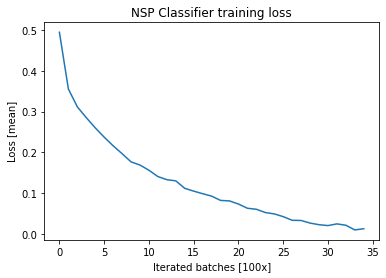

In [12]:
pylab.plot(loss_list)
pylab.xlabel('Iterated batches [100x]')
pylab.ylabel('Loss [mean]')
pylab.title('NSP Classifier training loss')
pylab.show()

## 5. Evaluation

Evaluation functions

In [13]:
def fpr(pred, labels):
    """ False positive rate
    Args:
        inputs (1D Tensor): vector with predicted binary numeric values
        labels (1D Tensor): vector with correct binary numeric values
    """
    fp = sum((pred == 1) & (labels == 0))
    tn = sum((pred == 0) & (labels == 0))
    
    return (fp/(fp+tn)).item()

def fnr(pred, labels):
    """ False negative rate
    Args:
        inputs (1D Tensor): vector with predicted binary numeric values
        labels (1D Tensor): vector with correct binary numeric values
    """
    fn = sum((pred == 0) & (labels == 1))
    tp = sum((pred == 1) & (labels == 1))
    
    return (fn/(fn+tp)).item()

def mcc(pred, labels):
    """ Mathews correlation coefficient
    Args:
        inputs (1D Tensor): vector with predicted binary numeric values
        labels (1D Tensor): vector with correct binary numeric values
    """
    fp = sum((pred == 1) & (labels == 0))
    tp = sum((pred == 1) & (labels == 1))
    fn = sum((pred == 0) & (labels == 1))
    tn = sum((pred == 0) & (labels == 0))
    
    return ((tp*tn-fp*fn)/torch.sqrt(((tp+fp)*(fn+tn)*(tp+fn)*(fp+tn)).float())).item()

def pcc(pred, labels):
    """ Pearson correlation coefficient
    Args:
        inputs (1D Tensor): vector with predicted numeric values
        labels (1D Tensor): vector with correct numeric values
    """
    x = pred - torch.mean(pred)
    y = labels - torch.mean(labels)
    
    return (torch.sum(x * y) / (torch.sqrt(torch.sum(x ** 2)) * torch.sqrt(torch.sum(y ** 2)))).item()

def mae(pred, labels):
    """ Mean absolute error
    Args:
        inputs (1D Tensor): vector with predicted numeric values
        labels (1D Tensor): vector with correct numeric values
    """
    
    return (sum(torch.min(torch.cat((abs(labels-pred).unsqueeze(1), abs(360-labels+pred).unsqueeze(1)), dim=1), dim=1)[0])/len(labels)).item()
    #return (sum(abs(labels - pred))/len(labels)).item()
    
def accuracy(pred, labels):
    """ Accuracy coefficient
    Args:
        inputs (1D Tensor): vector with predicted integer values
        labels (1D Tensor): vector with correct integer values
    """
    
    return (sum((pred == labels)) / len(labels)).item()

A seperate dataset is used to evaluate the model. Here is each class evaluated and the prediction benchmarks for the trained model are found.

In [14]:
# store evaluation results
results = {
    "SS8": 0,
    "SS3": 0,
    "disorder_mcc": 0,
    "disorder_fnr": 0,
    "RSA": 0,
    "ASA": 0,
    "psi": 0,
    "phi": 0,
}

# iterate through the evaluation dataset
with torch.no_grad():
    for data in CASP12_hhblits:
        # move data tensors to GPU if possible
        inputs, labels = data
        inputs, labels = inputs.to(device=device), labels.to(device=device)
        
        predictions = nsp_classifier(inputs) # predict values
        
        # Use only true sequences from seq mask
        predictions = [pred[labels[:, :, 0] == 1] for pred in predictions]
        labels = labels[labels[:, :, 0] == 1]
        
        # calculate the SS8 accuracy
        SS8_labels = torch.argmax(labels[:, 7:15], dim=1).flatten()
        SS8_pred = torch.argmax(predictions[0], dim=1).flatten()
        
        results["SS8"] += accuracy(SS8_pred, SS8_labels)
        
        # calculate the SS3 accuracy
        SS3_mask = torch.tensor([0,0,0,1,1,2,2,2], device=device)
        
        SS3_labels = torch.max(labels[:, 7:15] * SS3_mask, dim=1)[0].long().flatten()
        SS3_pred = torch.argmax(predictions[1], dim=1).flatten()
        
        results["SS3"] += accuracy(SS3_pred, SS3_labels)
        
        # calculate the FPR of disorder
        disorder_labels = labels[:, 1].flatten()
        disorder_pred = torch.argmax(predictions[2], dim=1).flatten()
        
        results["disorder_mcc"] += mcc(disorder_pred, disorder_labels)
        results["disorder_fnr"] += fnr(disorder_pred, disorder_labels)
        
        # calculate the RSA
        rsa_labels = labels[:, 6].flatten()
        rsa_pred = predictions[3].flatten()

        results['RSA'] += pcc(rsa_pred, rsa_labels)
        
        # calculate the ASA
        asa_labels = labels[:, 4].flatten()
        asa_max = labels[:, 17].flatten()

        results['ASA'] += pcc(asa_max * rsa_pred, asa_labels)
    
        # calculate the psi
        phi_labels = labels[:, 15].flatten()
        phi_pred = torch.atan2(predictions[4][:, 0], predictions[4][:, 1]).flatten()/np.pi*180
        
        results['psi'] += mae(phi_pred, phi_labels)

        # calculate the psi
        psi_labels = labels[:, 16].flatten()
        psi_pred = torch.atan2(predictions[5][:, 0], predictions[5][:, 1]).flatten()/np.pi*180
        
        results['phi'] += mae(psi_pred, psi_labels)
    
        
    # average prediction results 
    for method, _ in results.items():
        results[method] /= len(CASP12_hhblits)

print("RSA (PCC): {}".format(round(results["RSA"], 2)))
print("ASA (PCC): {}".format(round(results["ASA"], 2)))
print("SS8 [Q8]: {}".format(round(results["SS8"], 2)))
print("SS3 [Q3]: {}".format(round(results["SS3"], 2)))
print("Disorder (MCC): {}".format(round(results["disorder_mcc"], 2)))
print("Disorder (FNR): {}".format(round(results["disorder_fnr"], 3)))
print("Phi (MAE): {}".format(round(results["phi"], 2)))
print("Psi (MAE): {}".format(round(results["psi"], 2)))

RSA (PCC): 0.55
ASA (PCC): 0.58
SS8 [Q8]: 0.67
SS3 [Q3]: 0.8
Disorder (MCC): 0.55
Disorder (FNR): 0.017
Phi (MAE): 71.34
Psi (MAE): 111.05
